# Custom Enzyme Catalysed Reactions

This tutorial has been adapted from the tutorials in https://github.com/mic-pan/BGT_BiochemicalNetworkTutorials

In [ ]:
# Since BondGraphs is not yet in the package manager, we will need to include it directly from Github
# NOTE: You will need Julia >= 1.7
using Pkg; Pkg.add(url="https://github.com/jedforrest/BondGraphs.jl")
using BondGraphs

In [2]:
using Plots
using ModelingToolkit
using Catalyst

## Enzyme catalysed reactions
We can create custom reaction components which describe enzyme-catalyzed reaction mechanices, such as the Michaelis-Menten rate law.

In [3]:
# GlobalScope parameters do not have a namespace
@parameters R T
R, T = GlobalScope(R), GlobalScope(T)

@parameters t
D = Differential(t)

# Effort and flow variables
@variables E[1:2](t) F[1:2](t)

@parameters r1 r2 k_c e_T

4-element Vector{Num}:
  r1
  r2
 k_c
    e_T

In [4]:
# Custom component
ReMM = Dict(
    :description => """
    Michaelis-Menten reaction
    r1: Rate of reaction 1
    r2: Rate of reaction 2
    k_c: Affinity of complex relative to free enzyme
    e_T: Total amount of enzyme
    R: Universal Gas Constant
    T: Temperature
    """,
    :numports => 2,
    :variables => Dict(
        :parameters => Dict(
            r1 => 1,
            r2 => 1,
            k_c => 1,
            e_T => 1
        ),
        :globals => Dict(
            R => 8.314,
            T => 310.0
        )
    ),
    :equations => [
        0 ~ F[1] + F[2],
        0 ~ F[1] - e_T*r1*r2*k_c*(exp(E[1]/R/T) - exp(E[2]/R/T)) / (r1*exp(E[1]/R/T) + r2*exp(E[2]/R/T) + k_c*(r1+r2))
    ]
)

Dict{Symbol, Any} with 4 entries:
  :variables   => Dict{Symbol, Dict{Num}}(:parameters=>Dict{Num, Int64}(e_T=>1,…
  :description => "Michaelis-Menten reaction\nr1: Rate of reaction 1\nr2: Rate …
  :equations   => Equation[0 ~ F[1](t) + F[2](t), 0 ~ (-e_T*k_c*r1*r2*(exp(E[1]…
  :numports    => 2

In [5]:
ReMM[:equations]

2-element Vector{Equation}:
 0 ~ F[1](t) + F[2](t)
 0 ~ (-e_T*k_c*r1*r2*(exp(E[1](t) / (R*T)) - exp(E[2](t) / (R*T)))) / (k_c*(r1 + r2) + r1*exp(E[1](t) / (R*T)) + r2*exp(E[2](t) / (R*T))) + F[1](t)

We can add this component to the BondGraphs component library

In [6]:
addlibrary!(Dict(:ReMM => ReMM))
haskey(BondGraphs.DEFAULT_LIBRARY, :ReMM)

true

We will create a simple bond graph with this component: $S \rightleftharpoons P$

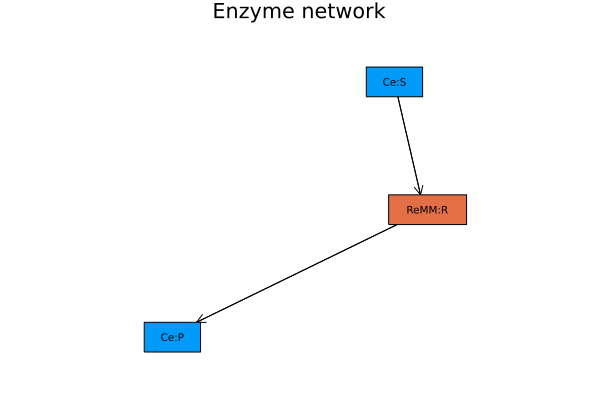

In [7]:
bg = BondGraph("Enzyme network")
S = Component(:Ce, "S"; K=1)
P = Component(:Ce, "P"; K=1)
ReMM = Component(:ReMM, "R"; r1=200, r2=200)

add_node!(bg, [S, P, ReMM])

connect!(bg, S, ReMM)
connect!(bg, ReMM, P)

plot(bg)

In [8]:
constitutive_relations(bg)

2-element Vector{Equation}:
 Differential(t)(S₊q(t)) ~ (R₊e_T*R₊k_c*R₊r1*R₊r2*(P₊K*P₊q(t) - S₊K*S₊q(t))) / (R₊k_c*R₊r1 + R₊k_c*R₊r2 + P₊K*R₊r2*P₊q(t) + R₊r1*S₊K*S₊q(t))
 Differential(t)(P₊q(t)) ~ (R₊e_T*R₊k_c*R₊r1*R₊r2*(S₊K*S₊q(t) - P₊K*P₊q(t))) / (R₊k_c*R₊r1 + R₊k_c*R₊r2 + P₊K*R₊r2*P₊q(t) + R₊r1*S₊K*S₊q(t))

In [9]:
constitutive_relations(bg; sub_defaults=true)

2-element Vector{Equation}:
 Differential(t)(S₊q(t)) ~ (200P₊q(t) - 200S₊q(t)) / (2 + P₊q(t) + S₊q(t))
 Differential(t)(P₊q(t)) ~ (200S₊q(t) - 200P₊q(t)) / (2 + P₊q(t) + S₊q(t))

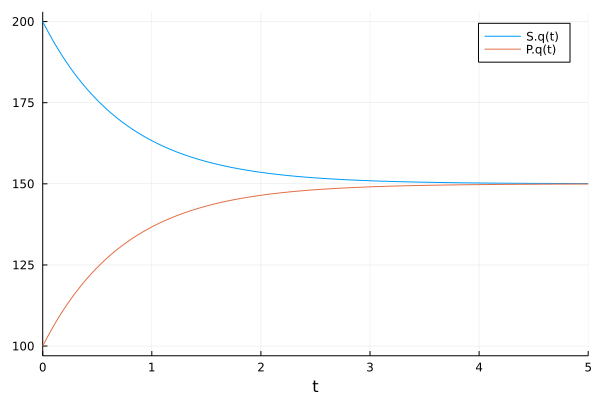

In [10]:
sol = simulate(bg, (0.,5.); u0=[200,100])
plot(sol)

A slightly more complicated example $A \rightleftharpoons B \rightleftharpoons C$

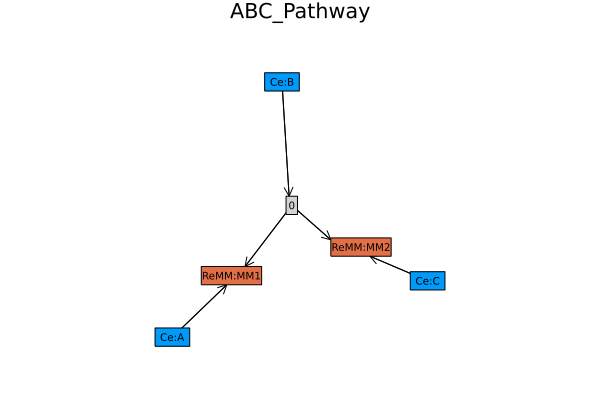

In [11]:
rn_abc = @reaction_network ABC_Pathway begin
    (1, 1), A <--> B
    (1, 1), B <--> C
end
bg = BondGraph(rn_abc)

# Set K values to integers (for easier simplifying)
bg.A.K, bg.B.K, bg.C.K = 1, 1, 1

# Swap in new reaction types
MM1 = Component(:ReMM, "MM1"; r1=100, r2=100)
MM2 = Component(:ReMM, "MM2"; r1=100, r2=100)

swap!(bg, bg.R1, MM1)
swap!(bg, bg.R2, MM2)

plot(bg)

In [12]:
constitutive_relations(bg; sub_defaults=true)

3-element Vector{Equation}:
 Differential(t)(A₊q(t)) ~ (100B₊q(t) - 100A₊q(t)) / (2 + A₊q(t) + B₊q(t))
 Differential(t)(B₊q(t)) ~ (200A₊q(t) + 200C₊q(t) + 200A₊q(t)*C₊q(t) - 200(B₊q(t)^2) - 400B₊q(t)) / ((2 + A₊q(t) + B₊q(t))*(2 + B₊q(t) + C₊q(t)))
 Differential(t)(C₊q(t)) ~ (100B₊q(t) - 100C₊q(t)) / (2 + B₊q(t) + C₊q(t))

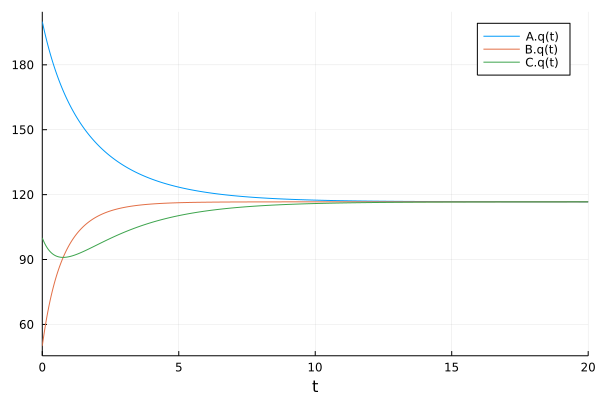

In [13]:
sol = simulate(bg, (0.,20.); u0=[200,50,100])
plot(sol)